# Make subnetworks

In [25]:
# 0. Import
import os
import sys

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

from scipy.io import mmread
from scipy.sparse import csr_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

which: no R in (/apps/software/standard/core/jupyterlab/3.6.3-py3.11:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/sbin:/apps/software/standard/core/jupyterlab/3.6.3-py3.11/bin:/home/apc5un/bedtools2/bin:/sfs/applications/202412_build/software/standard/core/miniforge/24.3.0-py3.11/bin:/opt/mam/9.1.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/slurm/current/bin:/opt/rci/bin:/share/resources/HPCtools:/opt/mam/current/bin:/opt/apptainer/current/bin)


'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

#### Load links and remove Mef2c connections from KO

In [5]:
thresh_num = 12000

links_atr = co.load_hdf5(file_path="./data/atrial-vent-040125/atriallinks_alpha1000.celloracle.links")
links_vent = co.load_hdf5(file_path="./data/atrial-vent-040125/ventlinks_alpha1000.celloracle.links")

links_atr.filter_links(p=.001, weight="coef_abs", threshold_number=thresh_num)
links_vent.filter_links(p=.001, weight="coef_abs", threshold_number=thresh_num)

In [6]:
links_atr.filtered_links['AtrialCMs'].to_csv(f"./data/atrial-vent-040125/atrial_{thresh_num}.csv", index=False)
links_vent.filtered_links['VentCMs'].to_csv(f"./data/atrial-vent-040125/vent_{thresh_num}.csv", index=False)

# Figure 1U – Atrial and VentricularSubnetworks

Higher quality version of these subnetworks can be made using the `visualize-pyvis.py` script.

This is the `plot_subnetwork()` function. It will return a `networkx` network for visualization.



In [8]:
def plot_subnetwork(network, tf_genes, targets):
    graph_df = {'source': [],
                 'target': [],
                 'weight': [],
                 'edge_cols': []}
    
    for curr_gene in tf_genes:
        curr_gene_df = network[network['source'] == curr_gene]
        gene_df_targs = curr_gene_df[curr_gene_df['target'].isin(targets)]

        for index, row in gene_df_targs.iterrows():
            graph_df['source'].append(row['source'])
            graph_df['target'].append(row['target'])
            graph_df['weight'].append(row['coef_mean'])
            if row['coef_mean'] > 0:
                graph_df['edge_cols'].append('green')
            else:
                graph_df['edge_cols'].append('red')

    graph_df = pd.DataFrame(graph_df)

    G = nx.from_pandas_edgelist(graph_df, source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    
    from pyvis.network import Network
    net = Network(notebook=True, directed=True)
    # net.force_atlas_2based(gravity=-30, central_gravity=0.005, spring_length=80, spring_strength=0.05, damping=0.8)
    net.force_atlas_2based(gravity=-20)
    net.from_nx(G)

    for edge in net.edges:
        if edge['width'] > 0:
            edge['color'] = 'grey'
            edge['arrowStrikethrough'] = False
        else:
            edge['color'] = 'red'
            edge['arrows'] = {"to": {"enabled": True, "type": "bar", "scaleFactor":.4}}

        edge['value'] = np.abs(edge['width'])

    for node in net.nodes:
        if node['id'] in tf_genes:
            node['shape'] = 'diamond'
            node['color'] = 'grey'
            node['size'] = 30
            node['font'] = {'size': 90, 'color': 'black'}
        else:
            node['color'] = 'grey' # Black is neither
            node['font'] = {'size': 1, 'color': 'black'}
            node['size'] = 2

    G_act = nx.from_pandas_edgelist(graph_df[graph_df.weight > 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
    G_inact = nx.from_pandas_edgelist(graph_df[graph_df.weight < 0], source='source', target='target', edge_attr='weight', create_using=nx.DiGraph())
            
    return net, G_act, G_inact

### Visualize Ventricular Subnetwork

In [15]:
# Selected genes of interest
genes_for_subnetwork = ['TBX5', 'NR2F2', 'MEF2C', 'NKX2-5', 'MEIS2', 'GATA4', 'HAND1', 'IRX4', 'HEY2', 'PLAGL1', 'NR2F1', 'HES4', 'E2F1', 'HEY1']

In [11]:
x = links_vent.filtered_links['VentCMs']
c = []
c = [c + list(x[x.source == curr_tf].target.values) for curr_tf in genes_for_subnetwork]
targets = [item for sublist in c for item in sublist]

In [16]:
net, G_act, G_inact = plot_subnetwork(links_vent.filtered_links['VentCMs'], genes_for_subnetwork, targets)
net.show('net.html')

net.html


### Visualize Atrial Subnetwork

In [13]:
x = links_atr.filtered_links['AtrialCMs']
c = []
c = [c + list(x[x.source == curr_tf].target.values) for curr_tf in genes_for_subnetwork]
targets = [item for sublist in c for item in sublist]

In [14]:
net, G_act, G_inact = plot_subnetwork(links_atr.filtered_links['AtrialCMs'], genes_for_subnetwork, targets)
net.show('net.html')

net.html


# Figure 1V – Centrality Bar Charts

In [52]:
links_atr.get_network_score()
links_vent.get_network_score()
centrality_type = 'betweenness_centrality' # 'degree_out'
atr = links_atr.merged_score[links_atr.merged_score.cluster == 'AtrialCMs'][centrality_type]
vent = links_vent.merged_score[links_vent.merged_score.cluster == 'VentCMs'][centrality_type]

In [53]:
tfs = ['HEY2', 'HAND1', 'E2F1', 'HES4', 'NR2F2', 'HEY1', 'NR2F1', 'PLAGL1', 'TBX5']
filtered = {'Atr': [], 'Vent': []}

for tf in tfs:
    if tf in vent.index:
        filtered['Vent'].append(vent.loc[[tf]].values[0])
    else:
        filtered['Vent'].append(0)
        
    if tf in atr.index:
        filtered['Atr'].append(atr.loc[[tf]].values[0])
    else:
        filtered['Atr'].append(0)
filtered = pd.DataFrame(filtered, index=tfs)

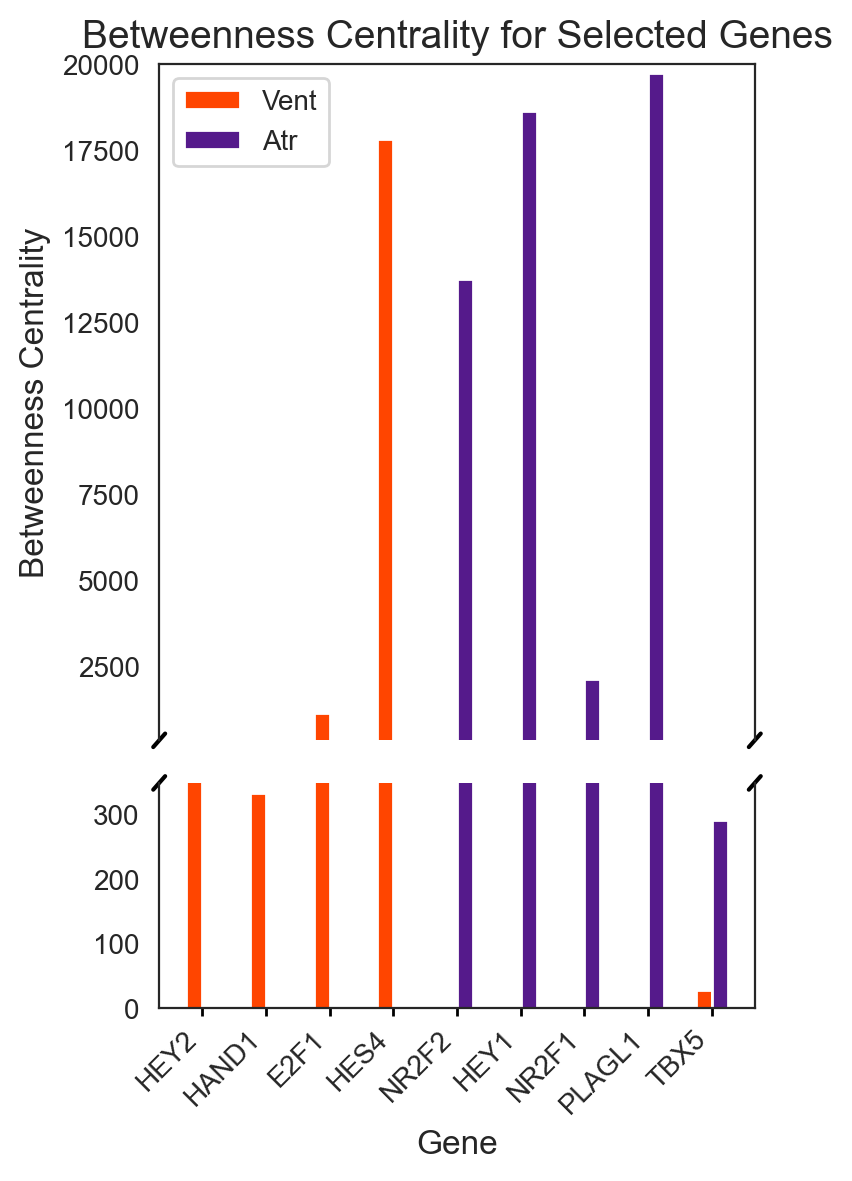

In [54]:
import matplotlib.pyplot as plt

x_positions = range(len(filtered.index))
bar_width = 0.25

# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 6), gridspec_kw={'height_ratios': [3, 1]})

# Plot upper part (50–12000)
ax1.bar([x - bar_width/2 for x in x_positions], filtered['Vent'], width=bar_width, label='Vent', color='#FF4500')
ax1.bar([x + bar_width/2 for x in x_positions], filtered['Atr'], width=bar_width, label='Atr', color='#551A8B')
ax1.set_ylim(350, 20000)

# Plot lower part (0–50)
ax2.bar([x - bar_width/2 for x in x_positions], filtered['Vent'], width=bar_width, label='Vent', color='#FF4500')
ax2.bar([x + bar_width/2 for x in x_positions], filtered['Atr'], width=bar_width, label='Atr', color='#551A8B')

ax2.set_ylim(0, 350)

# Hide the spines between ax1 and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # don't put tick labels at the top subplot
ax2.xaxis.tick_bottom()

# Add diagonal lines to show break
d = .01  # proportion of diagonal cut
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d*3, 1 + d*3), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d*3, 1 + d*3), **kwargs)  # bottom-right diagonal

# Labels and formatting
ax2.set_xlabel('Gene', fontsize=12)
ax1.set_ylabel('Betweenness Centrality', fontsize=12)
ax1.set_title('Betweenness Centrality for Selected Genes', fontsize=14)
ax2.set_xticks(x_positions)
ax2.set_xticklabels(filtered.index, rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=10)

plt.tight_layout()
plt.tick_params(axis='x', direction='out', length=3, width=1, color='black', bottom=True, top=False)
# matplotlib.rcParams['pdf.fonttype'] = 42
# plt.savefig(f'./figures/f-atr-vent_split_{centrality_type}.pdf', transparent=True)


plt.show()


In [42]:
centrality_type = 'degree_out'

In [43]:
atr = links_atr.merged_score[links_atr.merged_score.cluster == 'AtrialCMs'][centrality_type]
vent = links_vent.merged_score[links_vent.merged_score.cluster == 'VentCMs'][centrality_type]

In [44]:
tfs = ['HEY2', 'HAND1', 'E2F1', 'HES4', 'NR2F2', 'HEY1', 'NR2F1', 'PLAGL1', 'TBX5']
filtered = {'Atr': [], 'Vent': []}

for tf in tfs:
    if tf in vent.index:
        filtered['Vent'].append(vent.loc[[tf]].values[0])
    else:
        filtered['Vent'].append(0)
        
    if tf in atr.index:
        filtered['Atr'].append(atr.loc[[tf]].values[0])
    else:
        filtered['Atr'].append(0)
filtered = pd.DataFrame(filtered, index=tfs)

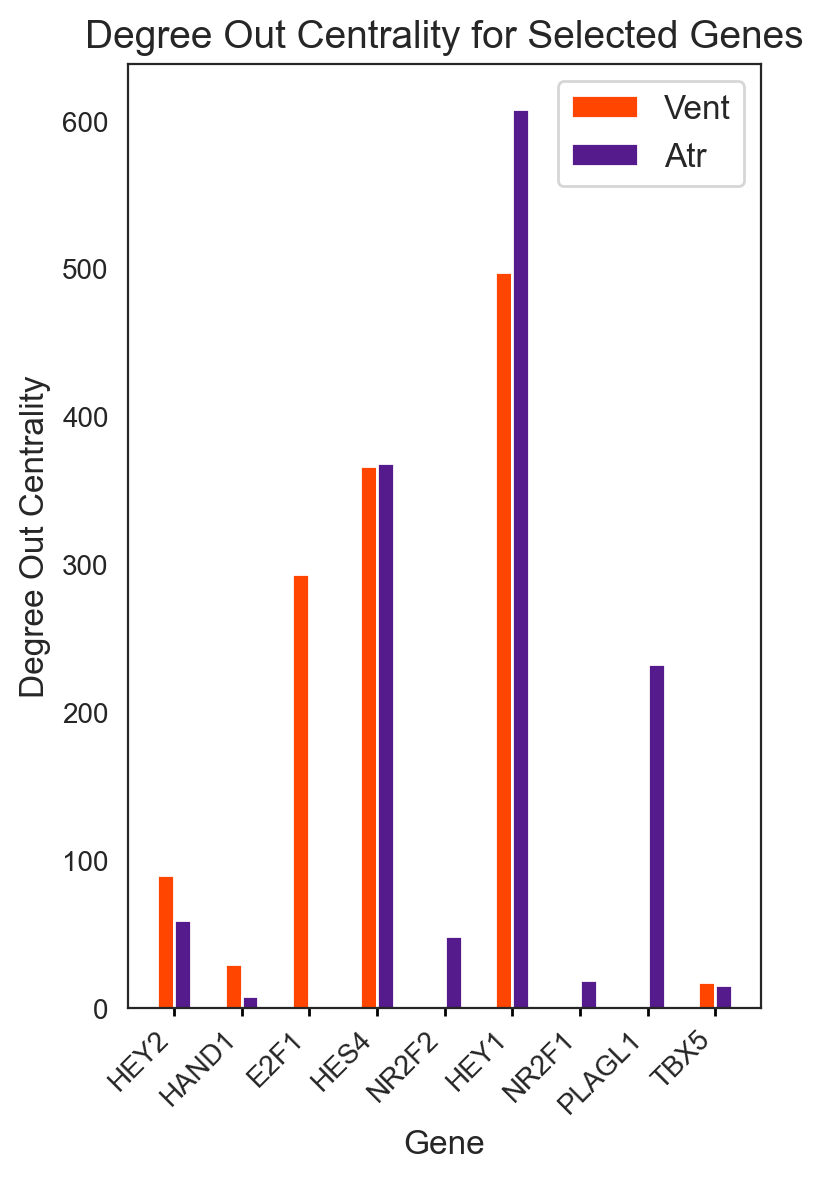

In [45]:
plt.figure(figsize=(4, 6))
x_positions = range(len(filtered.index))
bar_width = 0.25

# Plot each set of bars
plt.bar([x - bar_width/2 for x in x_positions], filtered['Vent'], width=bar_width, label='Vent', color='#FF4500')
plt.bar([x + bar_width/2 for x in x_positions], filtered['Atr'], width=bar_width, label='Atr', color='#551A8B')

# Adding labels and title
plt.xlabel('Gene', fontsize=12)
plt.ylabel('Degree Out Centrality', fontsize=12)
plt.title('Degree Out Centrality for Selected Genes', fontsize=14)
plt.xticks(x_positions, filtered.index, rotation=45, ha='right', fontsize=10)

plt.legend(fontsize=12)
plt.tight_layout()
# plt.ylim(0, 10000)
plt.tick_params(axis='x', direction='out', length=3, width=1, color='black', bottom=True, top=False)

# matplotlib.rcParams['pdf.fonttype'] = 42
# plt.savefig(f'./figures/f-atr-vent_{centrality_type}.pdf', transparent=True)

# Display the plot
plt.show()

# Figure 1W – Wheel Diagrams

In [58]:
def get_gene_targets(tf, links_wt, links_ko):
    wt_targets = links_wt[links_wt.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    ko_targets = links_ko[links_ko.sort_values('coef_mean')['source'].isin([tf])].target.unique()
    
    intersect_targets = [x for x in wt_targets if x in ko_targets]
    
    wt_only_targets = [x for x in wt_targets if x not in ko_targets]

    ko_only_targets = [x for x in ko_targets if x not in wt_targets]
    
    return intersect_targets, wt_only_targets, ko_only_targets

(-19.16211285082152, 19.16211288896849)

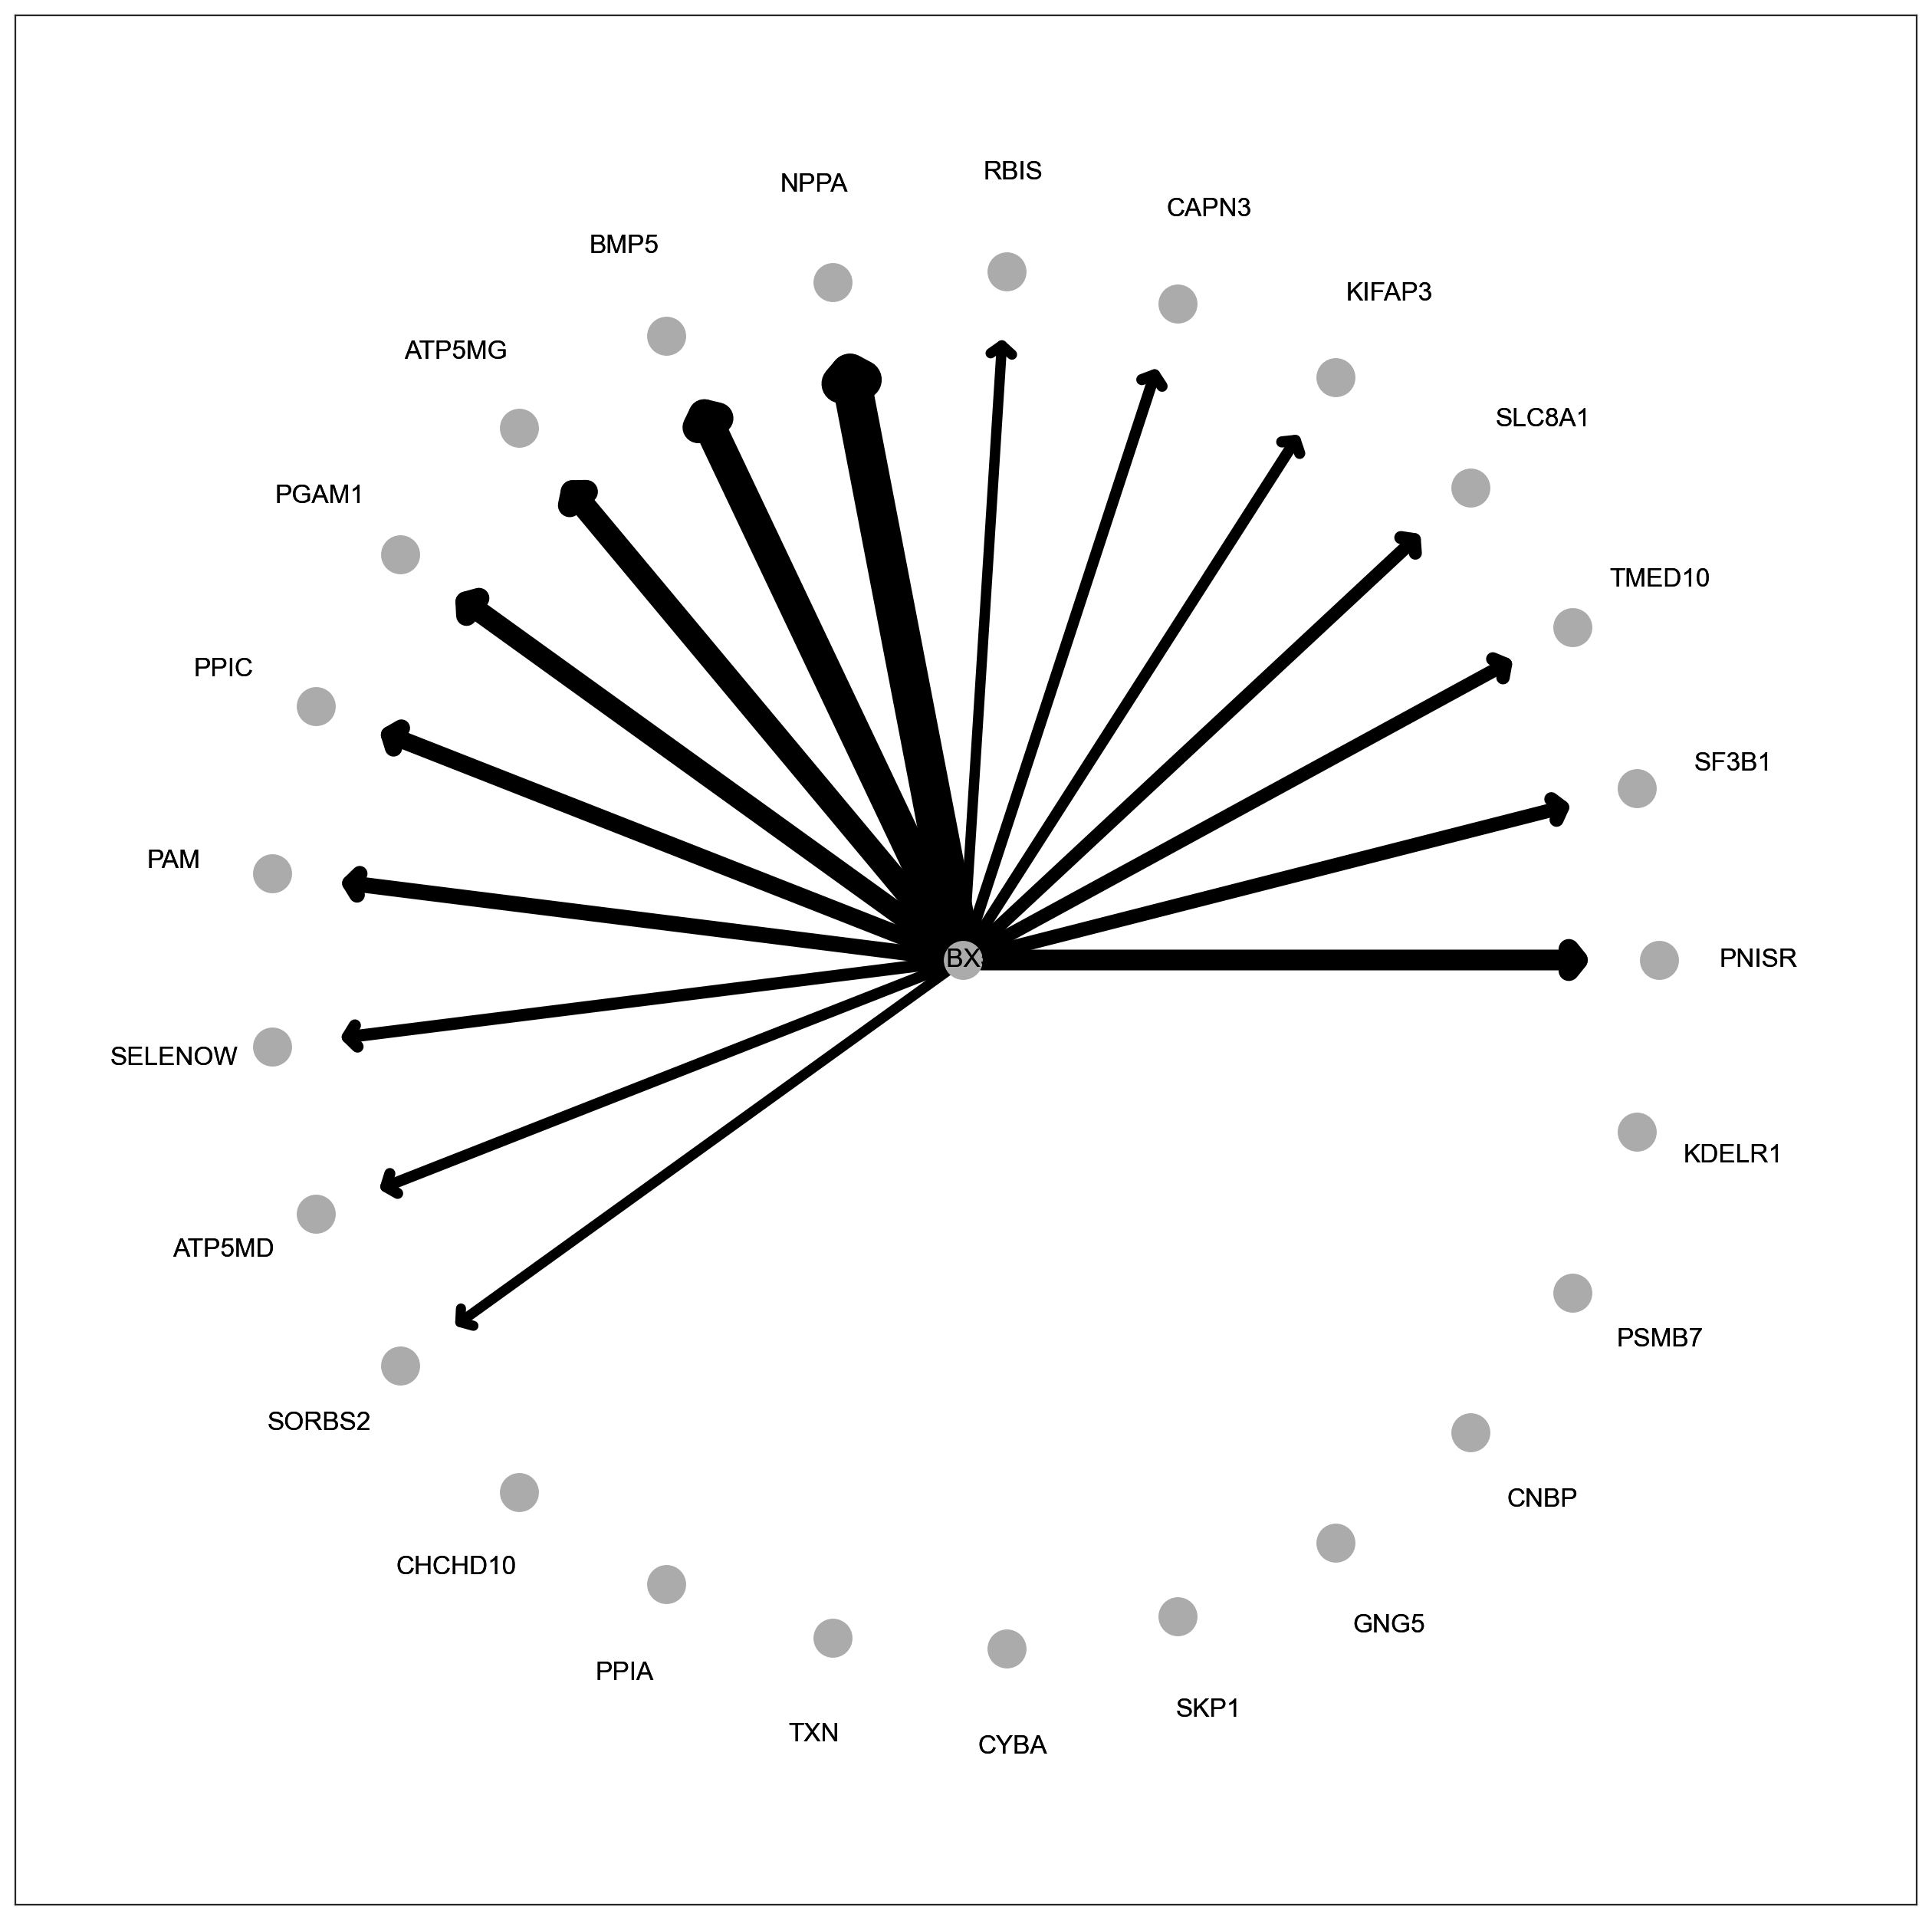

In [61]:
import networkx as nx
import numpy as np
import math
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

links_wt = links_atr.filtered_links['AtrialCMs']
links_ko = links_vent.filtered_links['VentCMs']

wt_or_ko = 'wt'
# wt_or_ko = 'ko'
tf = 'TBX5'

intersect_targets, wt_targets, ko_targets = get_gene_targets(tf, links_wt, links_ko)

matplotlib.rc('font', family='Arial')
fig, ax = plt.subplots(figsize=(16, 16))

all_nodes = wt_targets + intersect_targets +  ko_targets

G_act = nx.DiGraph()
G_act.add_nodes_from(all_nodes)
G_inhib = nx.DiGraph()
G_inhib.add_nodes_from(all_nodes)

pos = nx.circular_layout(G_act.subgraph(all_nodes))

G_act.add_node(tf)
G_inhib.add_node(tf)

if wt_or_ko == 'wt':
    tf_links = links_wt[links_wt.source == tf]
else:
    tf_links = links_ko[links_ko.source == tf]
    
for x in tf_links.target:
    connection = tf_links[tf_links.target == x]
    if connection.coef_mean.values[0] < 0:
        G_inhib.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='red')
    else:
        G_act.add_edge(tf, x, weight=connection.coef_abs.values[0]*40, color='black')
        

for i, G in enumerate([G_act, G_inhib]):
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight']*4 for u,v in edges]
    center_node = tf
    pos[center_node] = np.array([0, 0])
    
    pos_higher = nx.rescale_layout_dict(pos, 16)
    nx.draw_networkx_labels(G, pos_higher)
    
    pos_lower = nx.rescale_layout_dict(pos, 13)

    if i == 0:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('->', head_length=0.4, head_width=0.5))
    else:
        nx.draw_networkx_edges(G, pos_lower, width=weights, edge_color=colors, arrows=True, arrowstyle=matplotlib.patches.ArrowStyle('|-|', widthA=0, angleA=0, widthB=.5, angleB=0))


pos_mid = nx.rescale_layout_dict(pos, 14)
nx.draw_networkx_nodes(G, pos_mid, node_color="#ababab")

x_values, y_values = zip(*pos_higher.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(float(x_min - x_margin), float(x_max + x_margin))

y_max = max(y_values)
y_min = min(y_values)
y_margin = (y_max - y_min) * 0.1
plt.ylim(float(y_min - y_margin), float(y_max + y_margin))
# import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# plt.savefig(f"./data/{tf}-{wt_or_ko}.pdf", format='pdf')